In [1]:
import numpy as np
from PIL import Image, ImageOps
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

In [2]:
#Function to find X index for median Y value
def findindex(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [3]:
gels={'0g1':{2:{'t':0.3,'s':'H2B.1'},
         3:{'t':1.0,'s':'H2B.1'},
         4:{'t':3.0,'s':'H2B.1'},
         5:{'t':9.0,'s':'H2B.1'},
         6:{'t':27.0,'s':'H2B.1'},
         7:{'t':0.3,'s':'H2B.3'},
         8:{'t':1.0,'s':'H2B.3'},
         9:{'t':3.0,'s':'H2B.3'},
        10:{'t':9.0,'s':'H2B.3'},
        11:{'t':27.0,'s':'H2B.3'}},
       '1g2':{2:{'t':0.0,'s':'H2B.1'},
         3:{'t':0.3,'s':'H2B.1'},
         4:{'t':1.0,'s':'H2B.1'},
         5:{'t':3.0,'s':'H2B.1'},
         6:{'t':9.0,'s':'H2B.1'},
         7:{'t':27.0,'s':'H2B.1'},
         8:{'t':0.0,'s':'H2B.3'},
         9:{'t':0.3,'s':'H2B.3'},
        10:{'t':1.0,'s':'H2B.3'},
        11:{'t':3.0,'s':'H2B.3'},
        12:{'t':9.0,'s':'H2B.3'},
        13:{'t':27.0,'s':'H2B.3'}},
       '1g3':{2:{'t':0.0,'s':'H2B.1'},
         3:{'t':0.3,'s':'H2B.1'},
         4:{'t':1.0,'s':'H2B.1'},
         5:{'t':3.0,'s':'H2B.1'},
         6:{'t':9.0,'s':'H2B.1'},
         7:{'t':27.0,'s':'H2B.1'},
         8:{'t':0.0,'s':'H2B.6'},
         9:{'t':0.3,'s':'H2B.6'},
        10:{'t':1.0,'s':'H2B.6'},
        11:{'t':3.0,'s':'H2B.6'},
        12:{'t':9.0,'s':'H2B.6'},
        13:{'t':27.0,'s':'H2B.6'}}
      }
fileprefix='18083'
filemidfix='-lane'
filesuffix='v2.tiff'

In [4]:
for gel in gels.keys():
    for lane in gels[gel].keys():
        #Read in file then greyscale and invert for correct black on white
        img=Image.open('{0}{1}{2}{3:02}{4}'.format(fileprefix,gel,filemidfix,lane,filesuffix))
        img=ImageOps.grayscale(img)
        img=ImageOps.invert(img)
        #Import image as numpy array
        imgaa=np.asarray(img)
        #Sum pixels for each row of image
        sumaa2=np.sum(imgaa,axis=1).astype('int32')
        #Subtract background, estimated as value at Rf=0.97
        sumaa2=sumaa2-sumaa2[int(img.size[1]*0.97)]
        #Calculate cumulative sum down lane
        cumsumaa2=sumaa2.cumsum().astype(float)
        #Normalise to range 0-1
        cumsumaa2=cumsumaa2/max(cumsumaa2)
        #Use findindex to get X index of median Y
        medianrow=np.where(cumsumaa2==findindex(cumsumaa2,0.5))[0][0]
        gels[gel][lane]['rf']=medianrow/img.size[1]
        #print('{} lane {:02d}: median, Rf = {:4.2f}'.format(gels[gel][lane]['s'],lane,gels[gel][lane]['rf']))

In [5]:
df=pd.DataFrame.from_dict(
    dict([['{0}{1}l{2:02}'.format(fileprefix,gel,lane),gels[gel][lane]] for gel in gels.keys() for lane in gels[gel].keys()])
    ,orient='index').rename(columns={'t':'time','s':'histone','rf':'Rf'}
    ).sort_values(by=['histone','time'])
df

,time,histone,Rf
180831g2l02,0.0,H2B.1,0.120910
180831g3l02,0.0,H2B.1,0.123617
180830g1l02,0.3,H2B.1,0.134240
180831g2l03,0.3,H2B.1,0.209104
180831g3l03,0.3,H2B.1,0.198172
180830g1l03,1.0,H2B.1,0.184127
180831g2l04,1.0,H2B.1,0.300142
180831g3l04,1.0,H2B.1,0.215488
180830g1l04,3.0,H2B.1,0.267574
180831g2l05,3.0,H2B.1,0.279753


(0.1, 0.5)

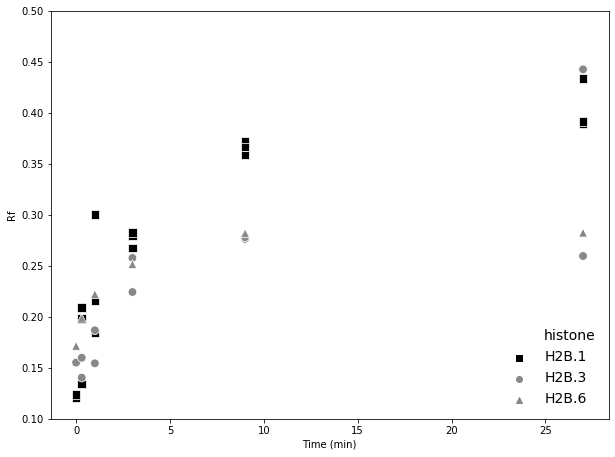

In [6]:
plt.figure(figsize=(10,7.5))
markers={'H2B.1':'s','H2B.3':'o','H2B.6':'^'}
g=sns.scatterplot(x='time',y='Rf',hue='histone',data=df,
                  style='histone',markers=markers,palette=['#000000','#888888','#888888'],s=75)
g.legend(loc='lower right',frameon=False,fontsize=14)
g.set_xlabel('Time (min)')
g.set_ylim(0.1,0.5)

In [7]:
#Curve fit function
#https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
def func(x, a, b, c):
    return a * np.log(b * x) + c

/Users/ajflaus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/ajflaus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


histone H2B.1: scalar=0.08010281508005668, log=0.023678380964922783, constant=0.4593180620723747
histone H2B.3: scalar=0.06320401725568818, log=0.0933069406562902, constant=0.28880179169405473
histone H2B.6: scalar=0.03299027460889958, log=0.18764467896650378, constant=0.24618324358317215


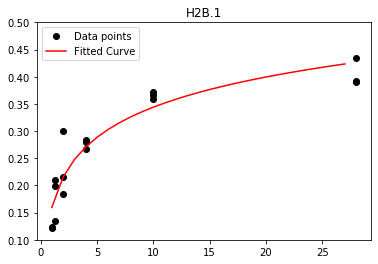

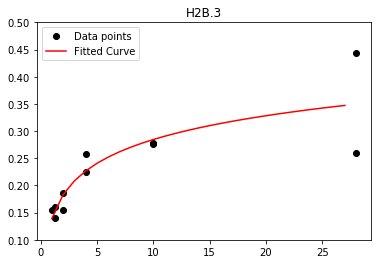

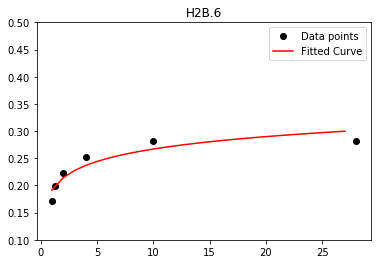

In [8]:
for histone in ['H2B.1','H2B.3','H2B.6']:
    dt=df.loc[(df.histone==histone)].sort_values(by='time')
    #Shift to t=1 because log(1) is zero
    xt=np.asarray(dt['time'].add(1.0).to_list())
    yt=np.asarray(dt['Rf'].to_list())
    popt, pcov = curve_fit(func, xt, yt)
    print('histone {}: scalar={}, log={}, constant={}'.format(histone, popt[0], popt[1], popt[2]))
    plt.figure()
    plt.plot(xt, yt, 'ko', label="Data points")
    curvepoints=range(int(max(xt)))
    plt.plot(curvepoints, func(curvepoints, *popt), 'r-', label="Fitted Curve")
    plt.ylim(0.1,0.5);
    plt.title(histone);
    plt.legend();

/Users/ajflaus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/ajflaus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


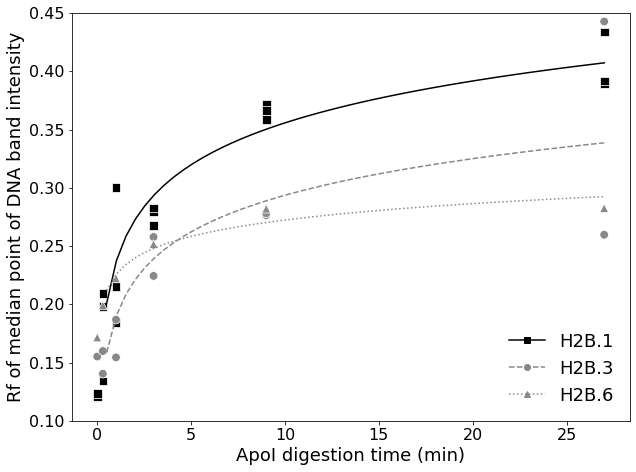

In [9]:
styles={'H2B.1':{'ms':'s','c':'#000000','ls':'-'},
        'H2B.3':{'ms':'o','c':'#888888','ls':'--'},
        'H2B.6':{'ms':'^','c':'#888888','ls':':'}}
fontsize=18
histones=styles.keys()

#Make the plot
plt.figure(figsize=(10,7.5))
g=sns.scatterplot(x='time',y='Rf',hue='histone',data=df,
                  style='histone',
                  markers=dict([[h,styles[h]['ms']] for h in histones]),
                  palette=dict([[h,styles[h]['c']] for h in histones]),
                  s=75)

#Set the plot parameters
g.set_ylim(0.1,0.45)
g.set_xlabel('ApoI digestion time (min)',fontsize=fontsize)
g.tick_params(labelsize=fontsize-2)
g.set_ylabel('Rf of median point of DNA band intensity',fontsize=fontsize)

#Draw legend
legendlines=[]
for histone in histones:
    legendlines.append(Line2D([0],[0],marker=styles[histone]['ms'],color=styles[histone]['c'],linestyle=styles[histone]['ls']))
g.legend(legendlines,histones,loc='lower right',frameon=False,fontsize=fontsize)

#Draw fit lines
for histone in histones:
    dt=df.loc[(df.histone==histone)].sort_values(by='time')
    xt=np.asarray(dt.loc[dt.time!=0]['time'].to_list())
    yt=np.asarray(dt.loc[dt.time!=0]['Rf'].to_list())
    popt, pcov = curve_fit(func, xt, yt)
    curvepoints=np.linspace(0,max(xt),54)
    g.plot(curvepoints, func(curvepoints, *popt),
           linestyle=styles[histone]['ls'],
           color=styles[histone]['c']);